# MCMC with `corrprior.CorrectPrior`
In this notebook, I demonstrate how you acn use MCMC with `corrprior.CorrectPrior` object

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import corrprior as Corrprior

In [3]:
m_nmf = Models.NMF(burst=True, emulator=True)
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # fburst
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst 
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

# generate fake observations
that galaxy properties not in the center of our prior

In [4]:
z_obs = 0.1

logssfr = -11
while np.abs(logssfr + 11) < 1: 
    _theta = prior.sample()
    logssfr = np.log10(m_nmf.avgSFR(prior.transform(_theta), zred=z_obs, dt=1)) - _theta[0]
print(logssfr)
theta_obs = prior.transform(_theta)
wave_obs, flux_obs = m_nmf.sed(theta_obs, zred=z_obs, vdisp=0, wavelength=np.linspace(3e3, 1e4, 1000))

[-12.74946751]


# define `corrprior.CorrectPrior` object
to impose uniform priors on galaxy properties

In [5]:
CP_kde = Corrprior.CorrectPrior(
    m_nmf, 
    prior, 
    zred=z_obs,
    props=['logavgssfr_1gyr', 'z_mw'], 
    range=[(-14., -9), (0., 0.04)],
    Nprior=100000, 
    method='kde',
    bandwidth=0.1,
    debug=True
)

... calculating log avg sSFR_1Gyr
... calculating mass-weighted Z
... fitting prior(derived prop)
... fitting pdf using kde


In [6]:
theta_deriv_obs = CP_kde._get_properties(theta_obs)[0]

In [7]:
_theta_prior = np.array([prior.sample() for i in range(10000)])
theta_prior = prior.transform(_theta_prior)
ftheta_prior = CP_kde._get_properties(theta_prior)

validate that our `corrprior.CorrectPrior` fits the prior on derived properties well

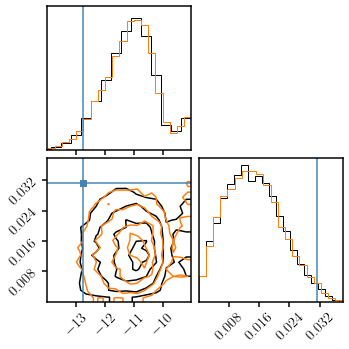

In [8]:
fig = DFM.corner(ftheta_prior, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
ftheta_priorhat = CP_kde.p_ftheta.sample(10000)
_ = DFM.corner(ftheta_priorhat, truths=theta_deriv_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

validate that our `corrprior.CorrectPrior` generates importance weights properly for the prior

In [9]:
w_imp = CP_kde.get_importance_weights(theta_prior, outlier=0.1, debug=True)

... clipping values outside 9.19998e-04, 1.78408e-01


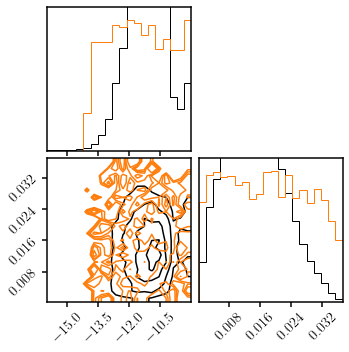

In [10]:
fig = DFM.corner(ftheta_prior, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(ftheta_prior, weights=w_imp, thetas=theta_deriv_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

# running MCMC without `corrprior.CorrectPrior` 
but correcting the prior using importance weights

In [11]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=prior)

In [12]:
mcmc_chain = desi_mcmc.run(
    wave_obs=wave_obs, 
    flux_obs=flux_obs, 
    flux_ivar_obs=np.ones(wave_obs.shape),
    zred=z_obs, 
    vdisp=0.,
    sampler='zeus',
    theta_start=prior.untransform(theta_obs),
    nwalkers=30, 
    burnin=0,
    opt_maxiter=2000,
    niter=1500, 
    debug=True)

Initialising ensemble of 30 walkers...


--- initializing the walkers ---
initial theta = [10.142281632721359, 0.4073310074425188, 0.6792925749383347, 0.9684935805140065, 0.923324778883877, 2.0768325845051177, 0.006222090387660003, 0.004912330998744156, 2.652766563814496, 1.0457691370525688, -0.3641204049949589]
log Posterior(theta0) = 0.000000
--- running MCMC ---


Sampling progress : 100%|██████████| 1500/1500 [12:05<00:00,  2.07it/s]

bestfit theta = [10.140946534935697, 0.5926685123598097, 0.13045993484890395, 0.009227688505513284, 0.2676438642857731, 0.9232647599691318, 2.0627336591782326, 0.006224865811841331, 0.004914332640201531, 2.653749782474274, 1.048729816185285, -0.3629033455170602]
log Posterior = -0.000640
Model.sed: redshift = 0.100000
Model.sed: ssp lum [  2229.58280709   1876.17291822   1431.22386269 ... 470653.3413755
 464162.14338737 461422.21508427]


In [13]:
flat_chain = desi_mcmc._flatten_chain(mcmc_chain['mcmc_chain'][200:,:,:])
w_imp = CP_kde.get_importance_weights(flat_chain, outlier=0.1)

Too few points to create valid contours
Too few points to create valid contours


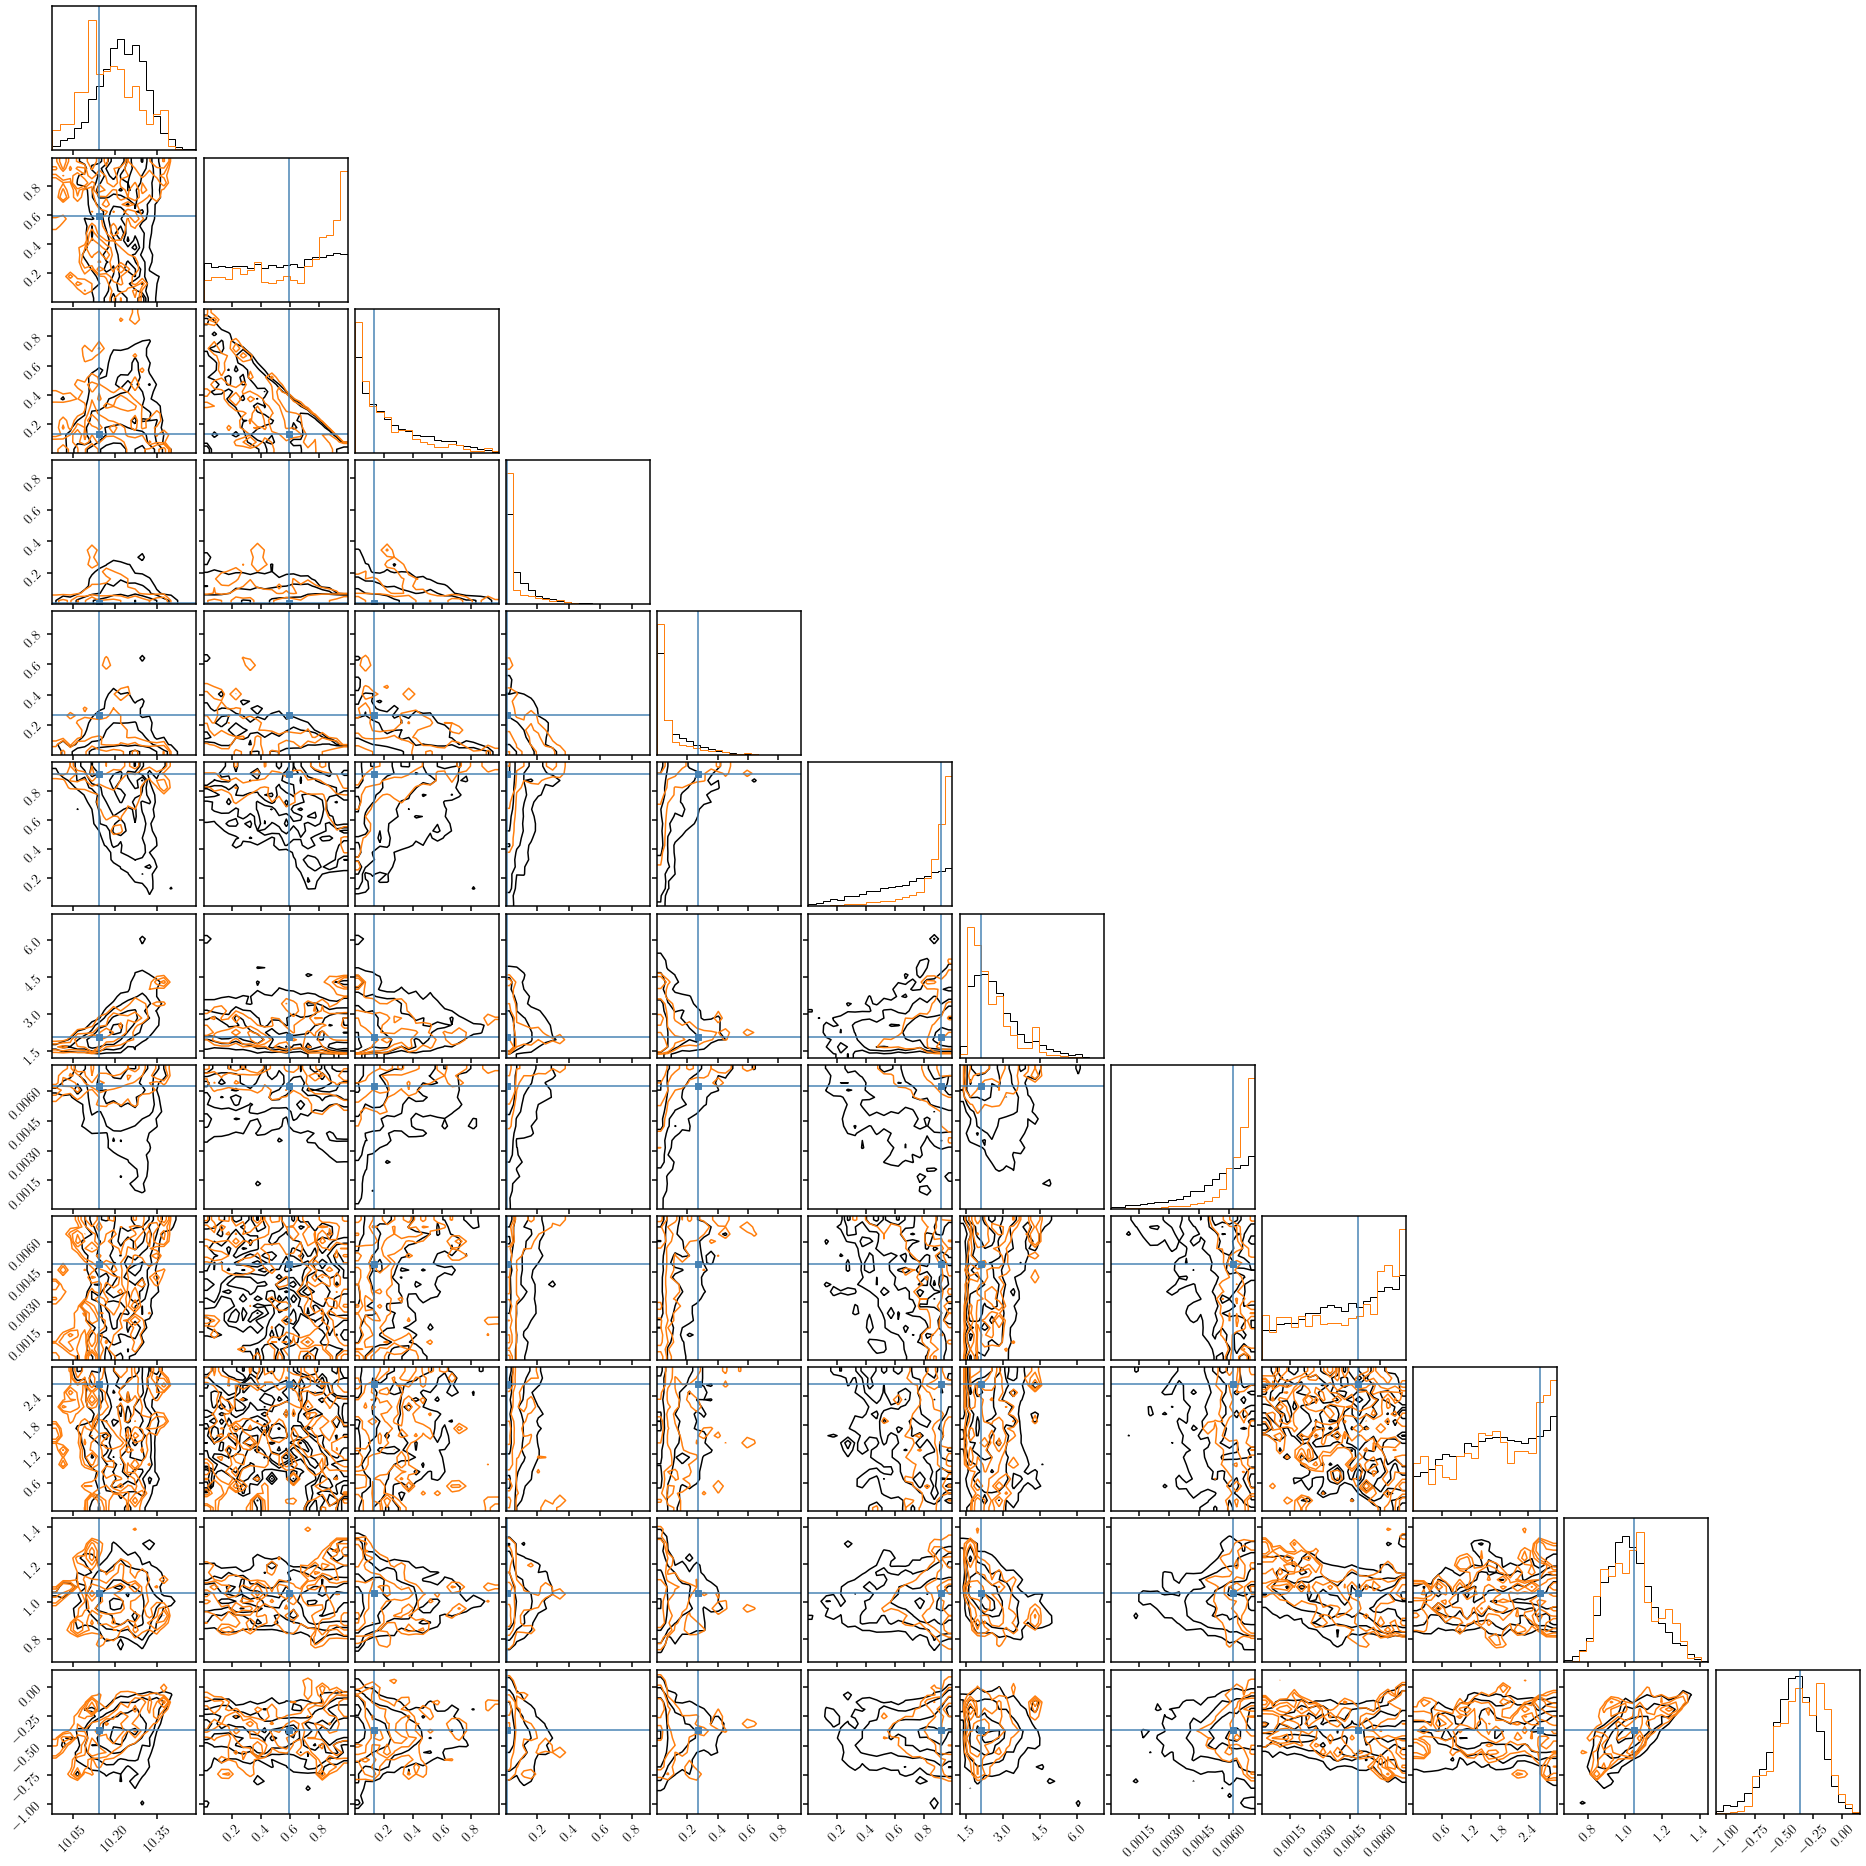

In [14]:
fig = DFM.corner(flat_chain, truths=theta_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(flat_chain, weights=w_imp, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

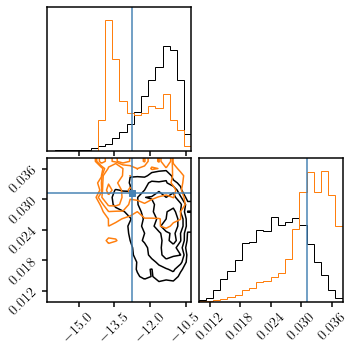

In [15]:
flat_deriv_chain = CP_kde._get_properties(flat_chain)
fig = DFM.corner(flat_deriv_chain, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(flat_deriv_chain, weights=w_imp, truths=theta_deriv_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

The importance weights, definitely reduce the bias, but looks a bit skewed. This might be due to numerical effects. Fortunately, we can

# run MCMC with `corrprior.CorrectPrior`
to run MCMC with CorrectPrior run on the fly

In [16]:
desi_mcmc_priorcorr = Infer.desiMCMC(
    model=m_nmf, 
    prior=prior,
    corrprior=CP_kde)

In [17]:
mcmc_chain_priorcorr = desi_mcmc_priorcorr.run(
    wave_obs=wave_obs, 
    flux_obs=flux_obs, 
    flux_ivar_obs=np.ones(wave_obs.shape),
    zred=z_obs, 
    vdisp=0.,
    sampler='zeus',
    theta_start=prior.untransform(theta_obs),
    nwalkers=30, 
    burnin=0,
    opt_maxiter=2000,
    niter=1500, 
    debug=True)

--- initializing the walkers ---
initial theta = [10.142281632721359, 0.4073310074425188, 0.6792925749383347, 0.9684935805140065, 0.923324778883877, 2.0768325845051177, 0.006222090387660003, 0.004912330998744156, 2.652766563814496, 1.0457691370525688, -0.3641204049949589]
log Posterior(theta0) = 5.151381


Initialising ensemble of 30 walkers...


--- running MCMC ---


Sampling progress : 100%|██████████| 1500/1500 [31:48<00:00,  1.27s/it]

bestfit theta = [10.143147877377698, 0.989319911038118, 0.005926325898057847, 0.003983033040453633, 0.0007707300233705286, 0.9912079229334829, 1.9536557814007194, 0.007281656226623082, 0.007086323714344607, 2.3998545639920295, 1.1096425627210083, -0.31170042698589556]
log Posterior = 13.423888
Model.sed: redshift = 0.100000
Model.sed: ssp lum [  2133.74065084   1780.81146985   1357.70650533 ... 484860.41355007
 478294.29974782 475607.91732134]


Too few points to create valid contours


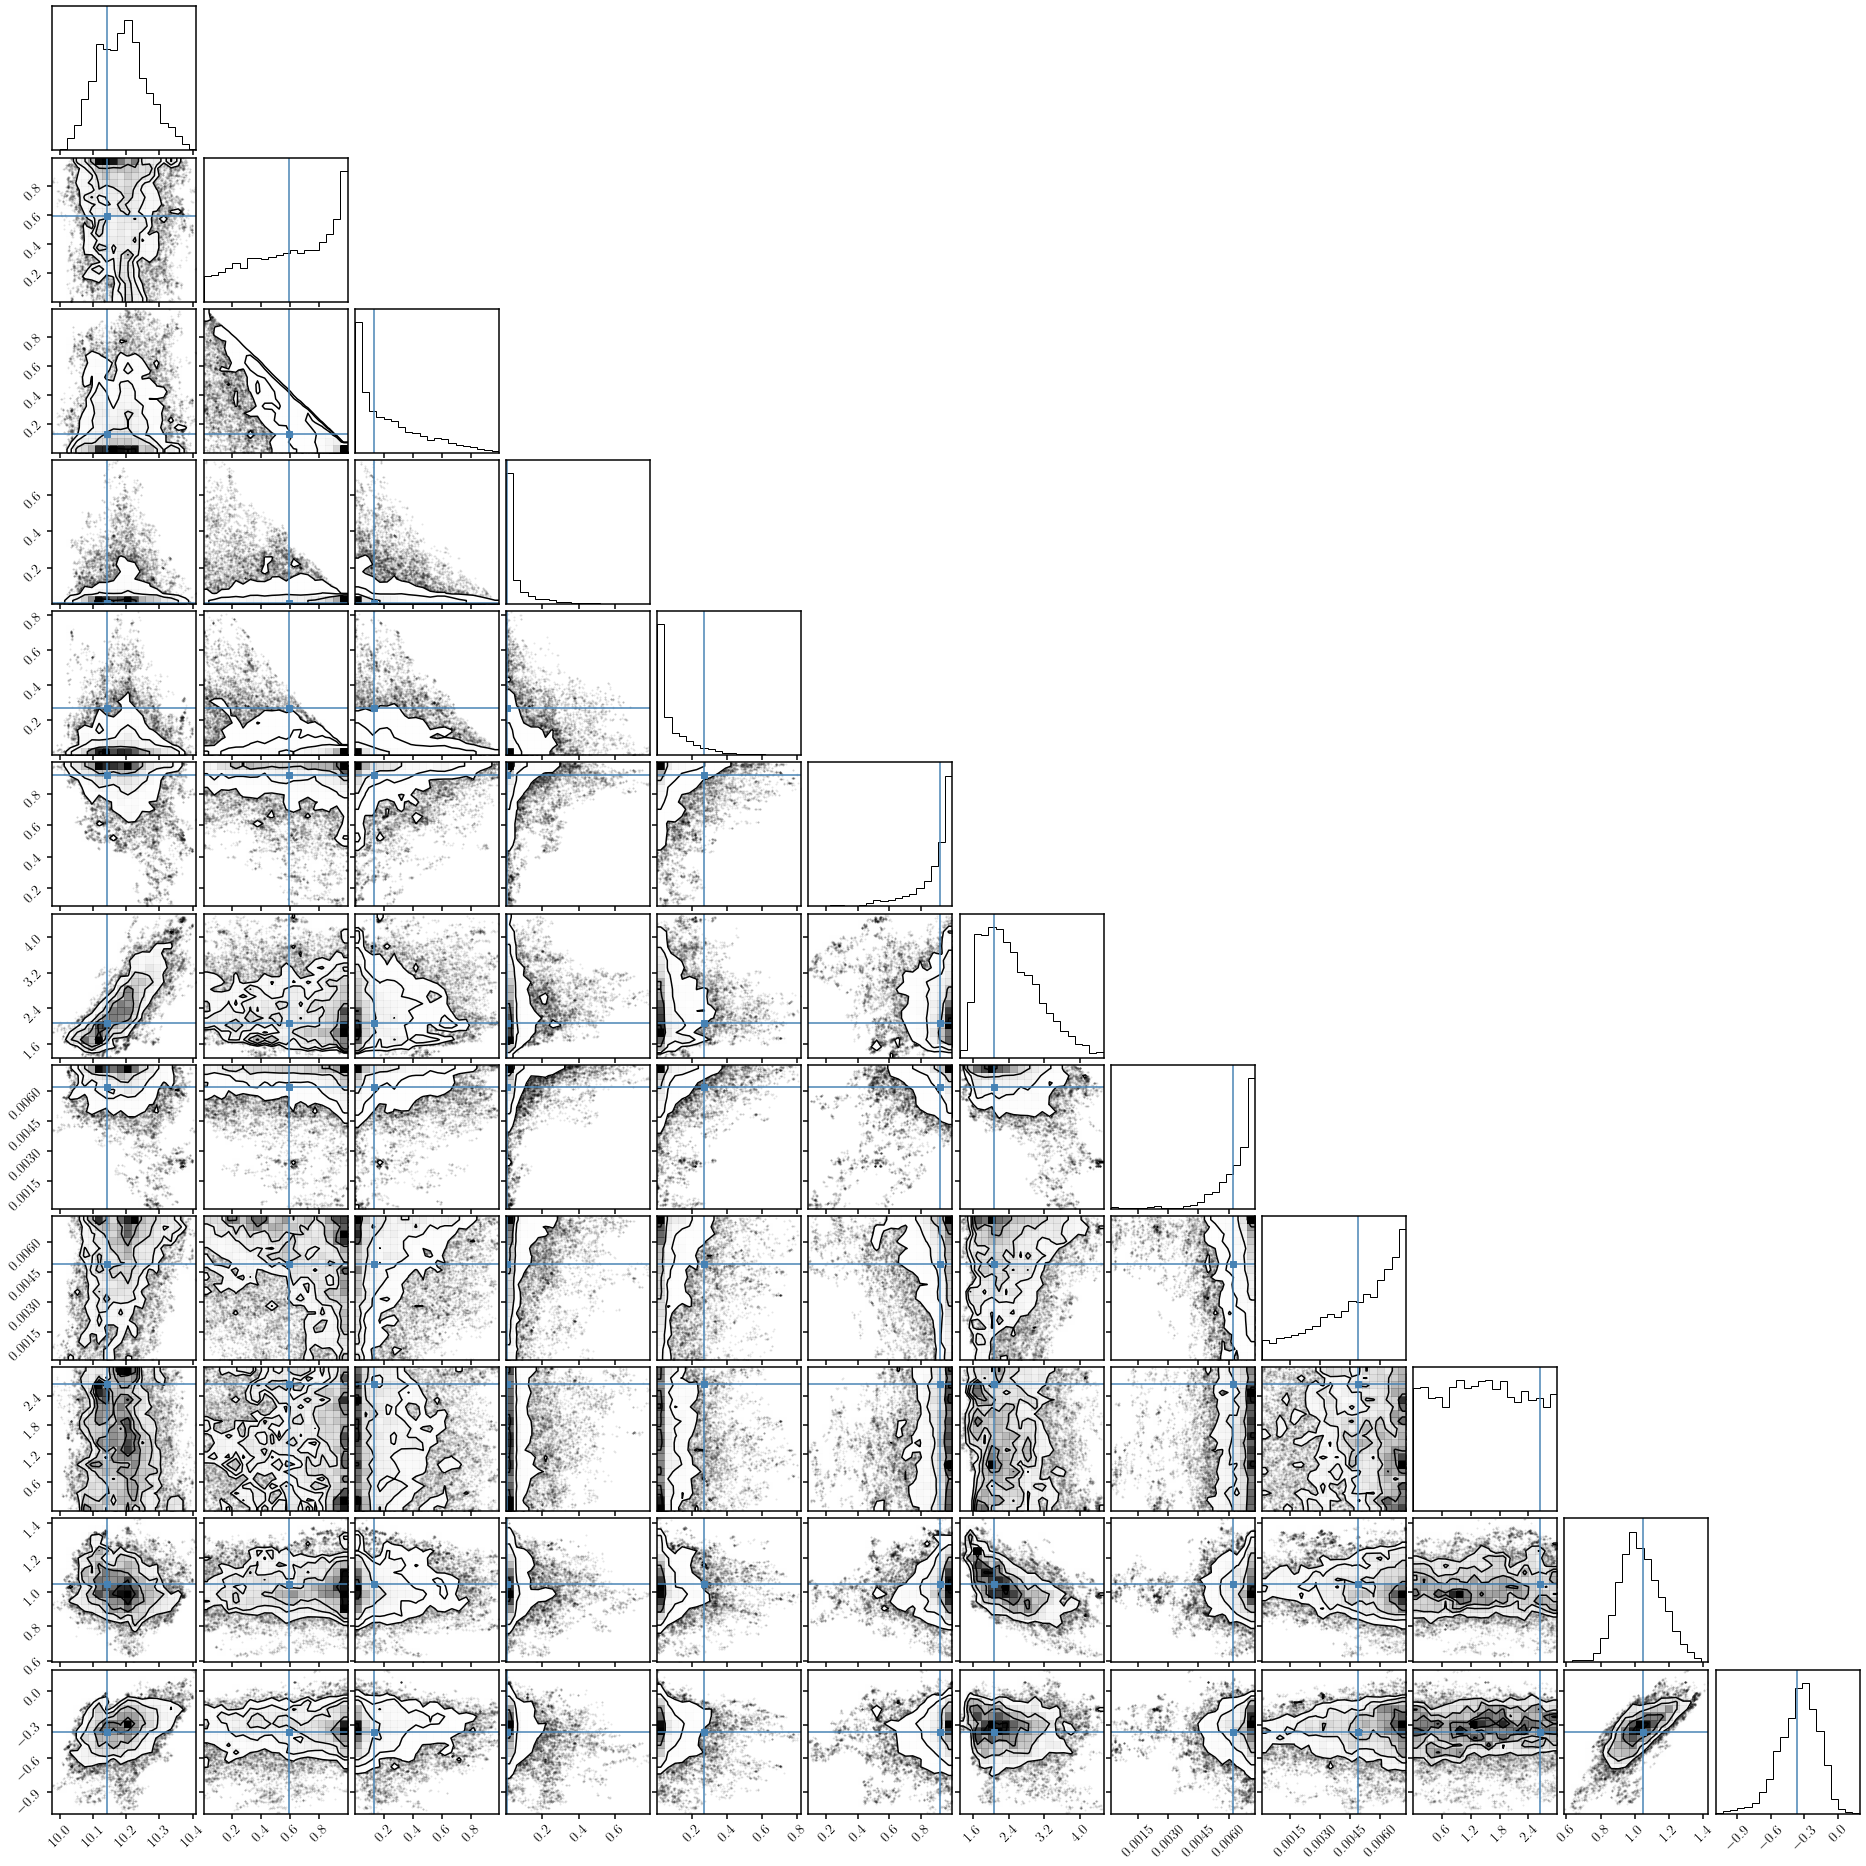

In [18]:
flat_chain_priorcorr = desi_mcmc._flatten_chain(mcmc_chain_priorcorr['mcmc_chain'][200:,:,:])
_ = DFM.corner(flat_chain_priorcorr, truths=theta_obs)

In [19]:
flat_deriv_chain_priorcorr = CP_kde._get_properties(flat_chain_priorcorr)

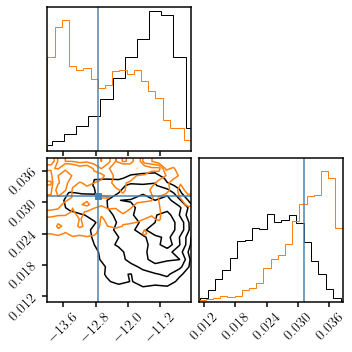

In [20]:
fig = DFM.corner(flat_deriv_chain, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False)
_ = DFM.corner(flat_deriv_chain_priorcorr, truths=theta_deriv_obs, hist_kwargs={'density': True}, plot_datapoints=False, plot_density=False, color='C1', fig=fig)

Nice.